# Flocks, Herds, and Traffic Jams

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from utils import decorate, savefig

Here's the `Driver` class from Chapter 10.

In [2]:
class Driver:
    
    def __init__(self, loc, speed=4):
        """Initialize the attributes.
        
        loc: position on track, in miles
        speed: speed in miles per hour
        """
        self.start = loc
        self.loc = loc
        self.speed = speed
        
    def choose_acceleration(self, dist):
        """Chooses acceleration based on distance.
        
        dist: distance from the car in front
        
        returns: acceleration
        """
        return 1
        
    def set_odometer(self):
        self.start = self.loc
        
    def read_odometer(self):
        return self.loc - self.start

And the Highway.

In [3]:
from Cell2D import Cell2D

class Highway(Cell2D):
    
    max_acc = 1
    min_acc = -10
    speed_limit = 40
    
    def __init__(self, n=10, length=1000, eps=0, constructor=Driver):
        """Initializes the attributes.
        
        n: number of drivers
        length: length of the track
        eps: variability in speed
        constructor: function used to instantiate drivers
        """
        self.length = length
        self.eps = eps
        self.crashes = 0

        # create the drivers
        locs = np.linspace(0, length, n, endpoint=False)
        self.drivers = [constructor(loc) for loc in locs]
        
        # and link them up
        for i in range(n):
            j = (i+1) % n
            self.drivers[i].next = self.drivers[j]
            
    def step(self):
        """Performs one time step."""
        for driver in self.drivers:
            self.move(driver)
            
    def move(self, driver):
        """Updates `driver`.
        
        driver: Driver object
        """
        # get the distance to the next driver
        dist = self.distance(driver)

        # let the driver choose acceleration
        acc = driver.choose_acceleration(dist)
        acc = min(acc, self.max_acc)
        acc = max(acc, self.min_acc)
        speed = driver.speed + acc
            
        # add random noise to speed
        speed *= np.random.uniform(1-self.eps, 1+self.eps)
        
        # keep it nonnegative and under the speed limit
        speed = max(speed, 0)
        speed = min(speed, self.speed_limit)
        
        # if current speed would collide with next driver, stop
        if speed > dist:
            speed = 0
            self.crashes += 1
            
        # update speed and loc
        driver.speed = speed
        driver.loc += speed
            
    def distance(self, driver):
        """Distance from `driver` to next driver.
        
        driver: Driver object
        """
        dist = driver.next.loc - driver.loc
        # fix wraparound
        if dist < 0:
            dist += self.length
        return dist
    
    def set_odometers(self):
        return [driver.set_odometer()
                for driver in self.drivers] 
    
    def read_odometers(self):
        return np.mean([driver.read_odometer()
                        for driver in self.drivers])
    
    def draw(self):
        """Draws the drivers and shows collisions.
        """
        drivers = self.drivers
        xs, ys = self.get_coords(drivers)
        plt.plot(xs, ys, 'bs', markersize=10, alpha=0.7)
        
        stopped = [driver for driver in self.drivers 
                  if driver.speed==0]
        xs, ys = self.get_coords(stopped, r=0.8)
        plt.plot(xs, ys, 'r^', markersize=12, alpha=0.7)
        
        plt.axis('off')
        plt.axis('equal')
        plt.xlim([-1.05, 1.05])
        plt.ylim([-1.05, 1.05])

    def get_coords(self, drivers, r=1):
        """Gets the coordinates of the drivers.
        
        Transforms from (row, col) to (x, y).
        
        drivers: sequence of Driver
        r: radius of the circle
        
        returns: tuple of sequences, (xs, ys)
        """
        locs = np.array([driver.loc for driver in drivers])
        locs *= 2 * np.pi / self.length
        xs = r * np.cos(locs)
        ys = r * np.sin(locs)
        return xs, ys

Make the animation:

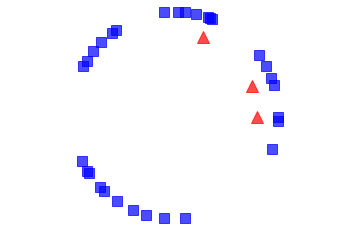

In [4]:
highway = Highway(30, eps=0.02)
highway.animate(frames=50, interval=0.2)

And generate the figure:

Saving figure to file figs/chap10-1


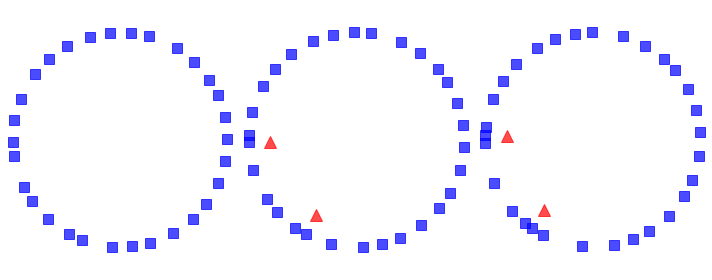

In [5]:
from utils import three_frame

highway = Highway(30, eps=0.02)
three_frame(highway, [16, 1, 1], seed=22)
savefig('figs/chap10-1')

Explore the relationship between `eps` and average speed.

In [6]:
def run_simulation(eps, constructor=Driver, iters=100):
    res = []
    for n in range(5, 100, 5):
        highway = Highway(n, eps=eps, constructor=constructor)
        for i in range(iters):
            highway.step()

        highway.set_odometers()
        for i in range(iters):
            highway.step()

        res.append((n, highway.read_odometers() / iters))
    
    return np.transpose(res)

Generate the figure:

Saving figure to file figs/chap10-2


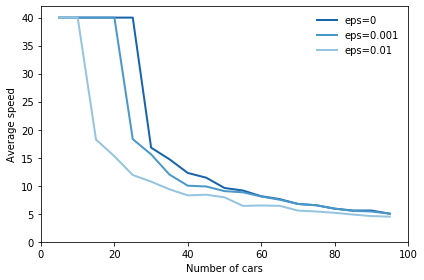

In [7]:
np.random.seed(20)
from utils import set_palette
set_palette('Blues', 4, reverse=True)

for eps in [0.0, 0.001, 0.01]:
    xs, ys = run_simulation(eps)
    plt.plot(xs, ys, label='eps=%g' % eps)
    
decorate(xlabel='Number of cars',
                 ylabel='Average speed',
                 xlim=[0, 100], ylim=[0, 42])

savefig('figs/chap10-2')

**Exercise:** In the traffic jam simulation, define a class, `BetterDriver`,
that inherits from `Driver` and overrides `choose_acceleration`.
See if you can define driving rules that do better than the basic
implementation in `Driver`.  You might try to achieve higher
average speed, or a lower number of collisions.

In [8]:
# So I overrided your first attempt in an attempt to account for self.speed and the last known distance between you and the next car 
# I got a much smoother slowdown by changing speed relative ot hte car in front, plus I averaged over twice your speed at the end
# I think I can do better though

class BetterDriver(Driver):
    
    
    def __init__(self, loc, speed=4):
        Driver.__init__(self,loc,speed)
        self.last_distance = -1
    
    def choose_acceleration(self, d):
        # step 1: looking forward at the car ahead of you's speed (if it's within collision distance)
        if self.last_distance == -1:
            self.last_distance = d
            return 1
        else:
            if d > self.last_distance or d > self.speed:
                self.last_distance = d
                return d - self.speed
            elif d < self.last_distance or d < self.speed:
                self.last_distance = d
                return d- self.speed
            else:
                self.last_distance = d
                return 0
            
            

In [39]:
# Attempt 2
# I started off with some refactoring to make it a lot nicer
# Then I was like "hmmm what if I changed it to more deply consider whether the last_distance or speed was the
# limiting factor here!
# Then I played around with some things and just had 0 success rate #rip
# Then I abandoned the idea to try again, more based on the first driver

class BetterDriver2(Driver):
    
    
    def __init__(self, loc, speed=4):
        Driver.__init__(self,loc,speed)
        self.last_distance = -1
    
    def choose_acceleration(self, d):
        # step 1: looking forward at the car ahead of you's speed (if it's within collision distance)
        ret_val = 0
        if self.last_distance == -1:
            ret_val = 1
        else:
            if d > self.last_distance or d > self.speed:
                if d > self.last_distance:
                    ret_val = d - self.speed
                else:
                    ret_val =  self.speed - d
            elif d < self.last_distance or d < self.speed:
                if d < self.last_distance:
                    ret_val = 1
                else:
                    ret_val =  self.speed - d
            else:
                ret_val = 2
        self.last_distance = d
        return ret_val/ 30

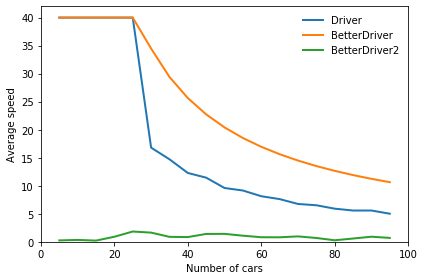

In [40]:
for constructor in [Driver, BetterDriver, BetterDriver2]:
    xs, ys = run_simulation(eps=0.0, constructor=constructor)
    plt.plot(xs, ys, label=constructor.__name__)
    
decorate(xlabel='Number of cars',
                 ylabel='Average speed',
                 xlim=[0, 100], ylim=[0, 42])

In [89]:
# Alright, let's change things around
# First, let's add immediate collision checking.
# At this point, I realized the bounds for acceleration are [-10,1], which will change things
class BetterDriver3(Driver):
    
    
    def __init__(self, loc, speed=4):
        Driver.__init__(self,loc,speed)
        self.last_distance = -1
    
           
    def choose_acceleration(self, d):
        ret_val = 0
        if self.last_distance == -1:
            ret_val = 0
        else:
            if d < self.speed*1.5: # "oh no, we gon die!"
                ret_val = -10 # slow down as FAST AS POSSIBLE
            elif self.speed > 15: # slow the hecc down.
                ret_val = -1
            else: # we're probably fine
                if d > self.last_distance or d > self.speed*2: # "hmm, the distance between the next car and myself is increasingg! (or there's a lot of space in front of me)"
                    ret_val = 1
                elif d < self.last_distance/4: # "hmm, the distance is a lot less than last time, or I have less distance than I thought. I should slow down."
                    retval = -1
                else: # Whatever should I do... accelerating seems "safe"?
                    ret_val = 1
        self.last_distance = d
        return ret_val 

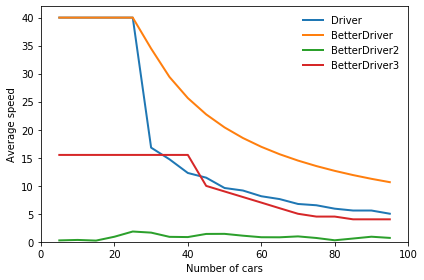

In [90]:
# At this point, I was getting sad. Nothing was really working and damn, sleep would be nice But I decided: one last chance. redemption.

for constructor in [Driver, BetterDriver, BetterDriver2,BetterDriver3]:
    xs, ys = run_simulation(eps=0.0, constructor=constructor)
    plt.plot(xs, ys, label=constructor.__name__)
    
decorate(xlabel='Number of cars',
                 ylabel='Average speed',
                 xlim=[0, 100], ylim=[0, 42])

In [108]:
# One more thing we should consider: self.speed (and save hte last speed)

class BetterDriver4(Driver):
    
    
    def __init__(self, loc, speed=4):
        Driver.__init__(self,loc,speed)
        self.last_distance = -1
        self.last_speed = -1
    
           
    def choose_acceleration(self, d):
        ret_val = 0
        if self.last_distance == -1:
            ret_val = 0
        else:
            if d < self.speed*1.5: # "oh no, we gon die!"
                ret_val = -5 # slow down QUICKLY
            else: # we're probably fine
                if d > self.last_distance: # "hmm, the distance between the next car and myself is increasingg!"
                    ret_val = 1
                elif d < self.last_distance/2: # "hmm, the distance is a lot less than last time"
                    ret_val = -2
                elif self.last_speed > self.speed: #maybe we should keep it steadier if we slowed down last time?
                    ret_val = 0.1
                else: # Whatever should I do... accelerating seems "safe"?
                    ret_val = 0.1
        self.last_distance = d
        self.last_speed = self.speed
        return ret_val 

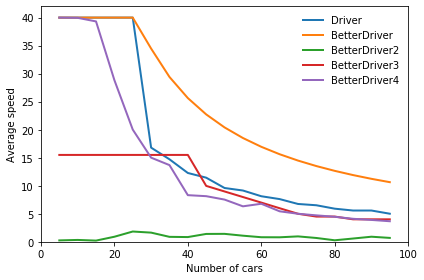

In [109]:
# Nope. I'm running this a lot and nothing obvious is coming to me. I'm going to back down on this assignment. RIP.

for constructor in [Driver, BetterDriver, BetterDriver2,BetterDriver3, BetterDriver4]:
    xs, ys = run_simulation(eps=0.0, constructor=constructor)
    plt.plot(xs, ys, label=constructor.__name__)
    
decorate(xlabel='Number of cars',
                 ylabel='Average speed',
                 xlim=[0, 100], ylim=[0, 42])